In [29]:
from typing import Callable

import re
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

In [30]:
Names = {
    "bot"               : "Best ZCajun Bot",
    "r1_r_sl_ss_5e-4"   : "RPPO(1, SS)",
    "r1_r_Dsl_ss_5e-4"  : "RPPO(1, SS, double dmg reward)",
    "s4_ss_5e-4"        : "PPO(4, SS)",
    "ss_1e-3"           : "PPO(1, SS)",
    "s4_ss_1e-3"        : "PPO(4, SS)",
    # "s4_ss_5e-4"        : "PPO(4, SS, halved lr)",
    "rgb_9e-4"          : "PPO(1, RGB)",
    # "ss_rgb_1e-3"       : "PPO(1, RGB+SS, )",
    "ss_rgb_1e-3_best"  : "PPO(1, RGB+SS)",
}

In [31]:
len("RPPO(1, SS, double dmg reward)")

30

In [32]:
def plot_distribution(map_id: str, include_rtss: bool=False, upper_bound: float=None, plot_box: bool=False):
    results_gtss = {f.split(os.path.sep)[-2]: np.load(f) for f in glob.glob(f"logs/{map_id}/*/performance.npy")}
    results_rtss = {}
    if include_rtss:
        results_rtss = {f.split(os.path.sep)[-2]: np.load(f) for f in glob.glob(f"logs/rtss_{map_id}/*/performance.npy") if "bot" not in f}
    results_gtss = {k.strip('_').replace("ppo_", '').replace("_final", '')  : v for k, v in results_gtss.items() if (not k[-1].isdigit()) and ("rgb" not in k or "rgb_9e-4" in k or "ss_rgb" in k)}
    results_rtss = {k.strip('_').replace("ppo_", '').replace("_final", '')  : v for k, v in results_rtss.items() if (not k[-1].isdigit()) and ("rgb" not in k or "rgb_9e-4" in k or "ss_rgb" in k)}
    results_gtss = {Names[k] : v for k, v in results_gtss.items() if k in Names}
    results_rtss = {Names[k] : v for k, v in results_rtss.items() if k in Names}
    lower_bound = 0
    if upper_bound is None:
        upper_bound = max([v.max() for v in results_gtss.values()]) + 10
    num_models = len(results_gtss) + len(results_rtss)

    tmp = [("Best ZCajun Bot", results_gtss["Best ZCajun Bot"])] 
    del results_gtss["Best ZCajun Bot"]

    results_combined = results_gtss #{k : map2_evals[k] for k, _ in best_models.values()}
    results_combined.update({
        k + " (RT)" : v for k, v in results_rtss.items()
    })
    tmp += sorted(sorted(results_combined.items(), key=lambda x: x[1].mean()), key=lambda x: np.median(x[1]))
    if plot_box:
        datas = []
        labels = []
        for i, (k, data) in enumerate(tmp, 1):
            datas.append(data)
            labels.append(f"{k:30s} ({data.mean():4.1f})")
        plt.grid()
        plt.xlim(lower_bound, upper_bound)
        plt.boxplot(datas, vert=False, patch_artist=True, meanline=True, tick_labels=labels)
        return labels
    else:
        for i, (k, data) in enumerate(tmp, 1):
            # print(data)
            plt.subplot(num_models, 1, i)
            if i == 1:
                plt.title(f"{map_id.upper().replace('_', ' ')}")
            Q1, Q2, Q3 = [int(np.percentile(data, 25 * i)) for i in (1, 2, 3)]
            min_, max_, mean_ = int(data.min()), int(data.max()), data.mean()
            plt.hist(data, np.arange(upper_bound), label=f"{k:30s} ({mean_:4.1f})")
            plt.xticks(np.arange(0, upper_bound, 5)+0.5, [str(i) for i in range(0, upper_bound, 5)], fontsize=8)
            ylim = 1500 if "Bot" in k else 150
            plt.plot([Q1+0.5, Q1+0.5], [0, ylim], 'y', linewidth=3)#, label=f"Q1={Q1:2d} (min={min_ :2d})")
            plt.plot([Q2+0.5, Q2+0.5], [0, ylim], 'b', linewidth=3)#, label=f"Q2={Q2:2d} (avg={mean_:.2f})")
            plt.plot([Q3+0.5, Q3+0.5], [0, ylim], 'r', linewidth=3)#, label=f"Q3={Q3:2d} (max={max_ :2d})")
            plt.legend(fontsize=8, loc="upper right")
            plt.ylim(lower_bound, ylim)
            plt.xlim(0, upper_bound)

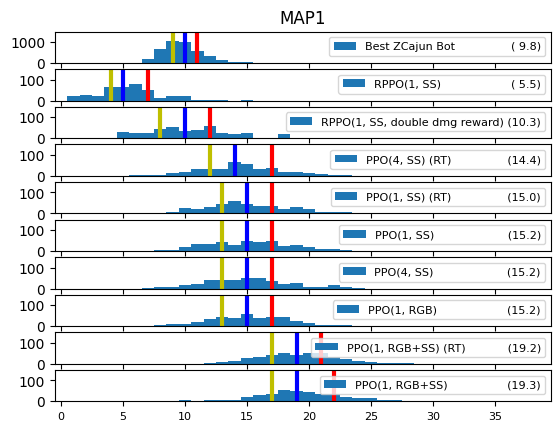

In [33]:
plot_distribution("map1", True, 40)

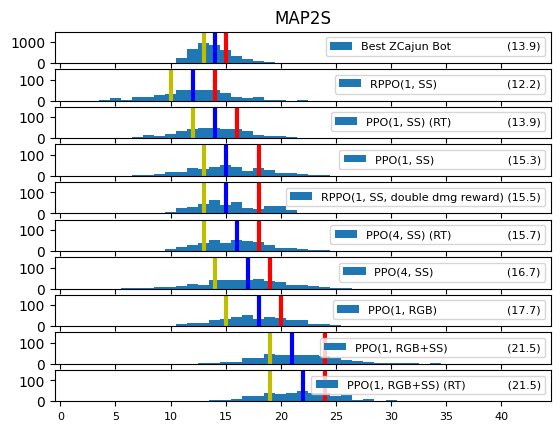

In [34]:
plot_distribution("map2s", True, 45)

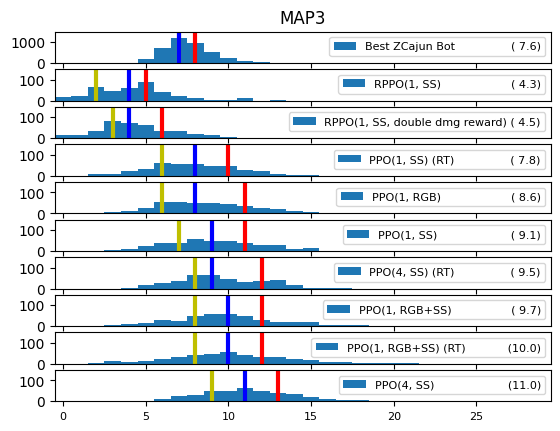

In [35]:
plot_distribution("map3", True, 30)

In [36]:
plot_distribution("map1", True, 35, plot_box=True);

ValueError: Invalid format specifier '30ls' for object of type 'str'

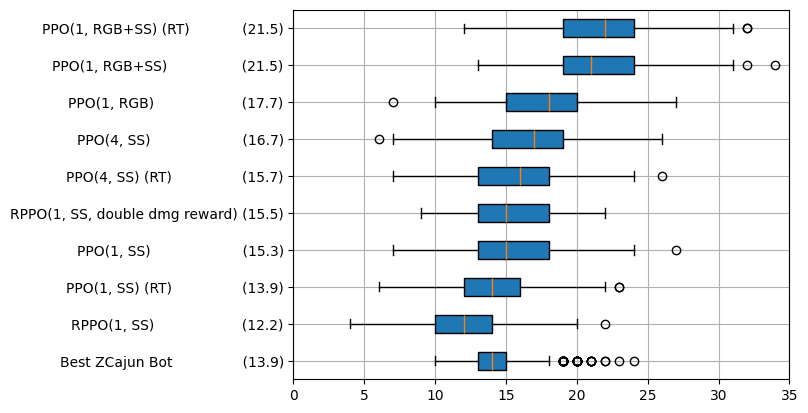

In [ ]:
plot_distribution("map2s", True, 35, plot_box=True);

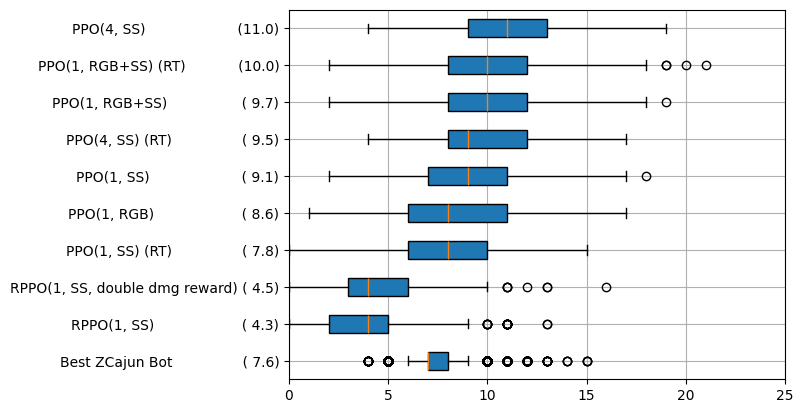

In [ ]:
plot_distribution("map3", True, 25, plot_box=True);